# Importing the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('perrin-freres-monthly-champagne-.csv')

In [3]:
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
data.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [5]:
data = data.dropna()

In [6]:
data['Month'] = pd.to_datetime(data['Month'])

In [7]:
data.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
100,1972-05-01,4618.0
101,1972-06-01,5312.0
102,1972-07-01,4298.0
103,1972-08-01,1413.0
104,1972-09-01,5877.0


In [8]:
data = data.set_index('Month')

In [9]:
data.head()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [10]:
data.columns = ['Sales']

In [11]:
data.tail()

,Sales
Month,
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0
1972-08-01,1413.0
1972-09-01,5877.0


In [12]:
data.shape

(105, 1)

In [13]:
data.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<AxesSubplot:xlabel='Month'>

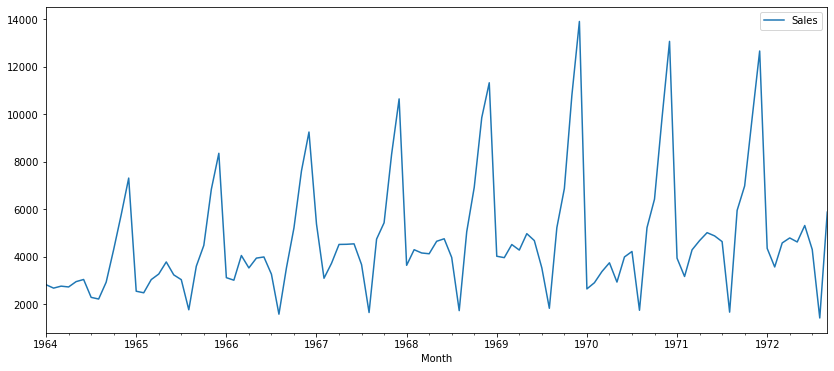

In [14]:
data.plot(figsize=(14,6))

## Stationarity check

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
adfuller_result = adfuller(data['Sales'], autolag='AIC')

In [17]:
adfuller_result

(-1.8335930563276237,
 0.3639157716602447,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

In [18]:
print('ADF Statistics:', adfuller_result[0])
print('p-value:', adfuller_result[1])
for key, value in adfuller_result[4].items():
    print('Critical Value:')
    print(' ', key, value)

ADF Statistics: -1.8335930563276237
p-value: 0.3639157716602447
Critical Value:
  1% -3.502704609582561
Critical Value:
  5% -2.8931578098779522
Critical Value:
  10% -2.583636712914788


p-value > 0.05, so we accept the null hypothesis, i.e, time series is non-stationary

## Making the series stationary

### Differencing

In [19]:
data['Seasonal First Difference'] = data['Sales'] - data['Sales'].shift(12)

In [20]:
data.head(15)

,Sales,Seasonal First Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
1964-06-01,3036.0,NaN
1964-07-01,2282.0,NaN
1964-08-01,2212.0,NaN
1964-09-01,2922.0,NaN


In [22]:
adfuller_result = adfuller(data['Seasonal First Difference'].dropna(), autolag='AIC')

In [23]:
print('ADF Statistics:', adfuller_result[0])
print('p-value:', adfuller_result[1])
for key, value in adfuller_result[4].items():
    print('Critical Value:')
    print(' ', key, value)

ADF Statistics: -7.626619157213163
p-value: 2.060579696813685e-11
Critical Value:
  1% -3.503514579651927
Critical Value:
  5% -2.893507960466837
Critical Value:
  10% -2.583823615311909


p-value < 0.05, so we reject the null hypothesis, i.e, time series is now stationary

<AxesSubplot:xlabel='Month'>

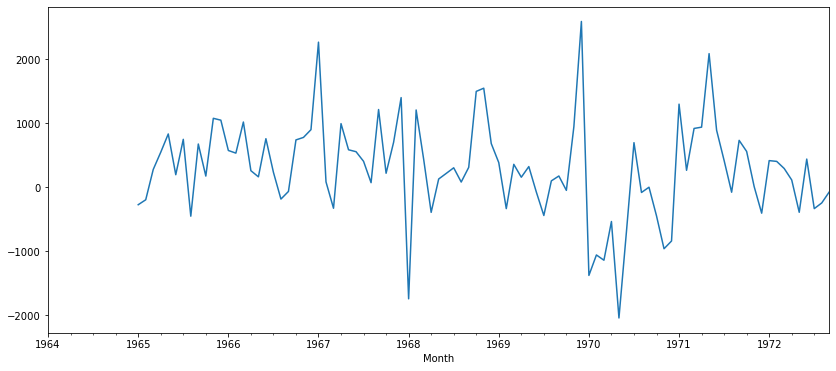

In [25]:
data['Seasonal First Difference'].plot(figsize=(14,6))

### ACF and PACF to determine the order of AR and MA in the model

In [26]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

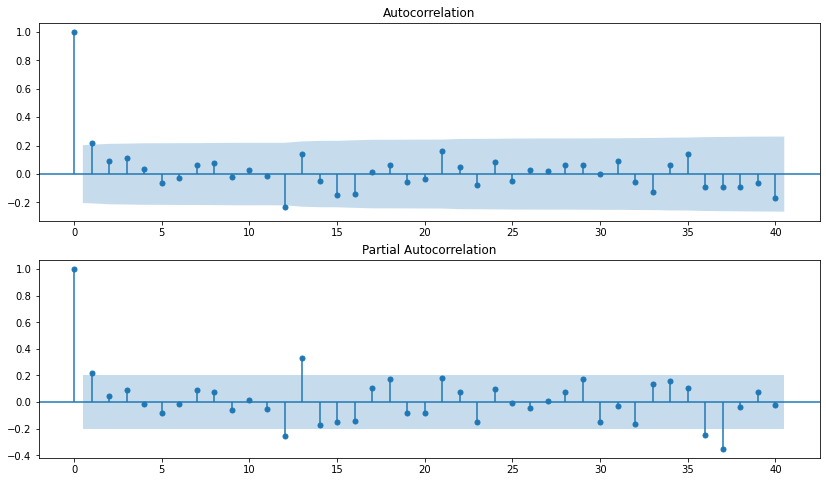

In [30]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

Identification of an AR model is often best done with the PACF. For an AR model, the order is at that point where the theoretical PACF “shuts off”,i.e, theoretically partial autocorrelations are equal to 0 beyond that point. Here the point is at 1

Identification of an MA model is often best done with the ACF rather than the PACF. For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. Here the point is at 1

# ARIMA Model

In [52]:
from statsmodels.tsa.arima_model import ARIMA

In [55]:
model = ARIMA(data['Seasonal First Difference'].dropna(), order=(1,1,1))    # for non-seasonal data d=1

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

In [56]:
model_fitted = model.fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [57]:
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARIMA Model Results                                  
=======================================================================================
Dep. Variable:     D.Seasonal First Difference   No. Observations:                   92
Model:                          ARIMA(1, 1, 1)   Log Likelihood                -739.804
Method:                                css-mle   S.D. of innovations            735.096
Date:                         Wed, 28 Jul 2021   AIC                           1487.607
Time:                                 21:39:56   BIC                           1497.695
Sample:                             02-01-1965   HQIC                          1491.679
                                  - 09-01-1972                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -4.8757      3.531     -1.381      0.167     -11.795       2.044
ar.L1.D.Seasonal First Difference     0.2021      0.103      1.958      0.050      -0.000       0.405
ma.L1.D.Seasonal First Difference    -0.9999      0.033    -30.266      0.000      -1.065      -0.935
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.9473           +0.0000j            4.9473            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Month'>

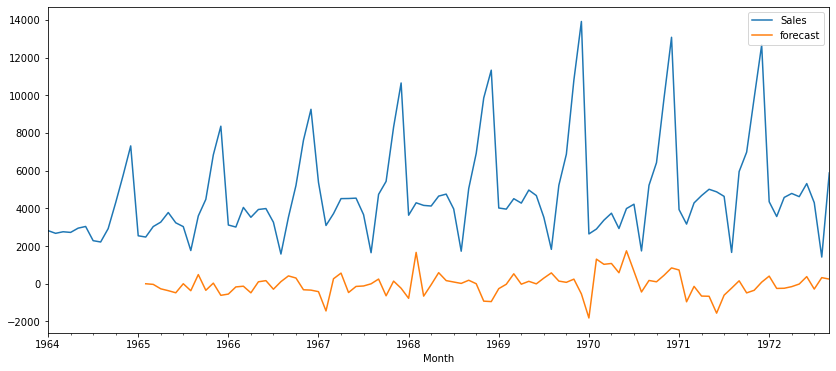

In [66]:
data['forecast']=model_fitted.predict()
data[['Sales','forecast']].plot(figsize=(14,6))

ARIMA Model didn't work here, because ARIMA model doesn't work well in seasonal data

# Seasonal ARIMA Model

In [62]:
sarimax_model = sm.tsa.statespace.SARIMAX(data['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [63]:
sarimax_model_fitted = sarimax_model.fit()

<AxesSubplot:xlabel='Month'>

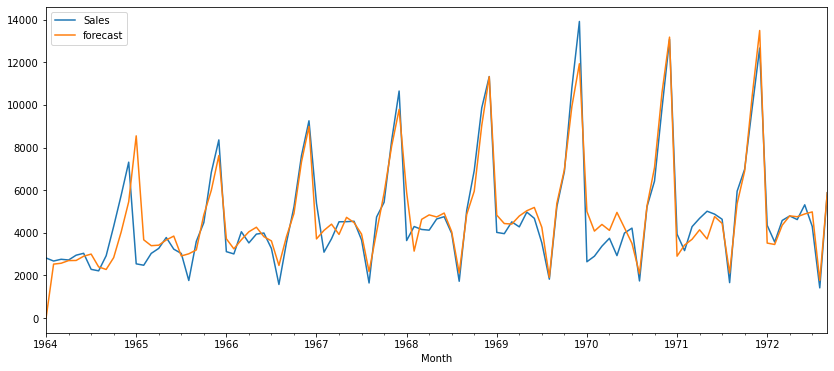

In [64]:
data['forecast']=sarimax_model_fitted.predict()
data[['Sales','forecast']].plot(figsize=(14,6))

# Future Prediction

In [41]:
from pandas.tseries.offsets import DateOffset

In [42]:
future_dates = [data.index[-1] + DateOffset(months=x) for x in range(0,24)]

In [43]:
future_dates_data = pd.DataFrame(index=future_dates[1:], columns=data.columns)

In [44]:
future_dates_data

,Sales,Seasonal First Difference,forecast
1972-10-01,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN
1973-06-01,NaN,NaN,NaN
1973-07-01,NaN,NaN,NaN


In [46]:
future_data = pd.concat([data, future_dates_data])

<AxesSubplot:>

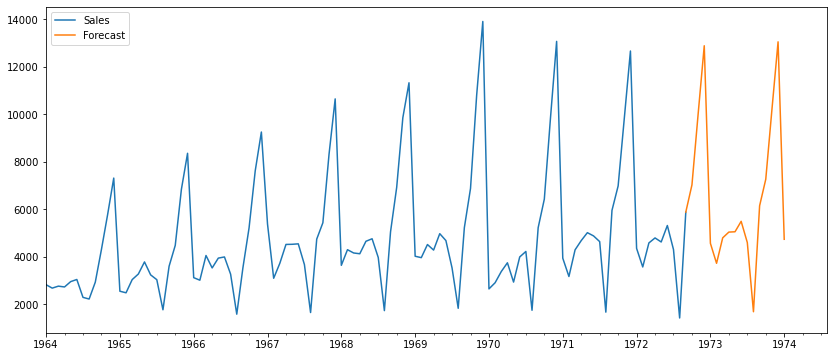

In [49]:
future_data['Forecast'] = sarimax_model_fitted.predict(104,120)
future_data[['Sales', 'Forecast']].plot(figsize=(14,6))